## Sign Language Prediction Using Deep Neural Networks in Real-time



# Final Tuned & Trained Model (Accuracy: 94.85%)

# About the Dataset

Supervised Learning Dataset

[Sign Language](https://www.kaggle.com/datamunge/sign-language-mnist) dataset contains 28x28 images of hands depicting the 26 letters of the English alphabet.

Data is pre-processed and is fed into the convolutional neural network to correctly classify each image as the letter it represents.

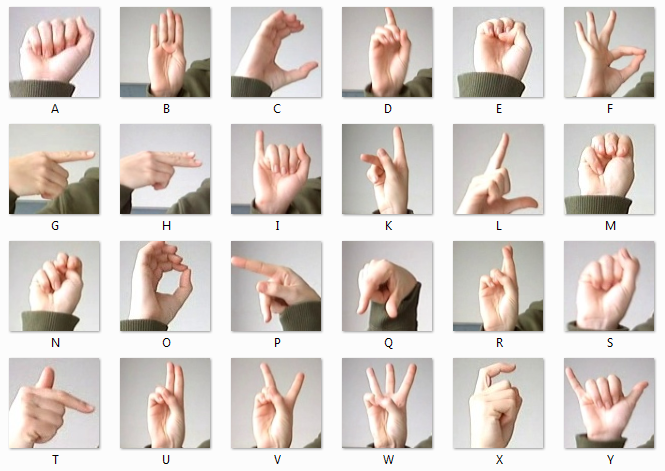

# Importing libraries

In [5]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

#Downloading the training and test sets:

In [16]:
# Downloading training & testing datasets using file id's

# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 129MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 97.4MB/s]


In [7]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

#Visualizing the dataset

In [8]:
import pandas as pd

file_path = './sign_mnist_train.csv'

# Reading the dataset into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first 5 rows
display(df.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


 ## Parsing the dataset (Splitting data into Training & Test datasets)

 This function reads a file passed as input and return 2 numpy arrays, one containing the labels and one containing the 28x28 representation of each image within the file.

- The first row contains the column headers, so you should ignore it.

- Each successive row contains 785 comma-separated values between 0 and 255
  - The first value is the label

  - The rest are the pixel values for that picture


In [9]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    # Initialize empty lists to store labels and pixel data
    labels = []
    pixel_data = []

    # Using csv.reader and passing in the appropriate delimiter
    csv_reader = csv.reader(file, delimiter=',')

    # Skipping the header row (header row contains 'label', 'pixel1', 'pixel2', 'pixel3', 'pixel4')
    header = next(csv_reader)

    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Extract the label and pixel data into label and pixel arrays
        label = int(row[0])  # 'label' is in the first column of the dataset
        pixels = [int(x) for x in row[1:]]  # pixel data starts from the second column to the end

        # Append the label and pixel data to their respective lists
        labels.append(label)
        pixel_data.append(pixels)

    # Converting the list of pixel data to a NumPy array with the desired shape and dtype
    images = np.array(pixel_data, dtype=float)  # Convert to float64
    images = images.reshape(-1, 28, 28)  # Reshaping 1D array of data into (27455, 28, 28)
    labels = np.array(labels, dtype=float)

    return images, labels

In [10]:
# Testing for correct sizes
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays (Single rows in the dataset)

Now that we have converted the initial csv data into a format that is compatible with computer vision tasks, lets see how the images of the dataset look like:

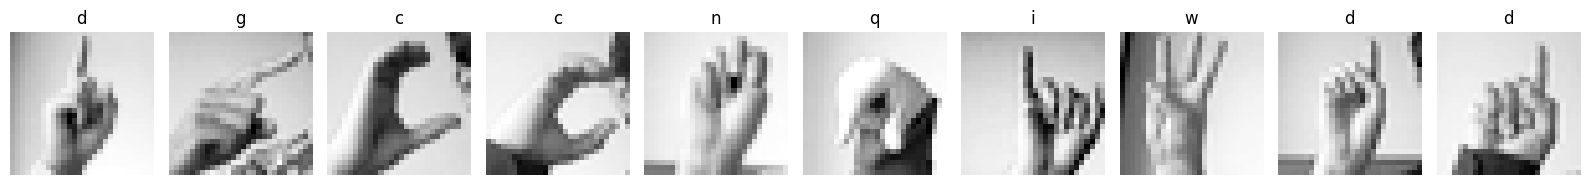

In [11]:
# Plotting a sample of 10 images from the training set for visualization
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

Now that we have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this complete the `train_val_generators` function below.

In [12]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
# Expanding the images to include  color dimension to it
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # setting arguments to augment the images to enhance the training set diversity
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  # Storing the augmented training images
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Storing the augmented testing set images
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [13]:
# Testing your generators for correct sizes
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

Define the architecture of the model.

The `create_model`function returns a Keras' model that uses the `Sequential` API.

The last layer of your model is built to have a number of units equal to the number of letters in the English alphabet. It uses an activation function that will output the probabilities per letter. So Softmax function is used.

Aside from defining the architecture of the model, compiling it so make sure to use a `loss` function is suitable for multi-class classification.

In [14]:
def create_model():

  model =  tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = (28,28,1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flattening the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])


  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

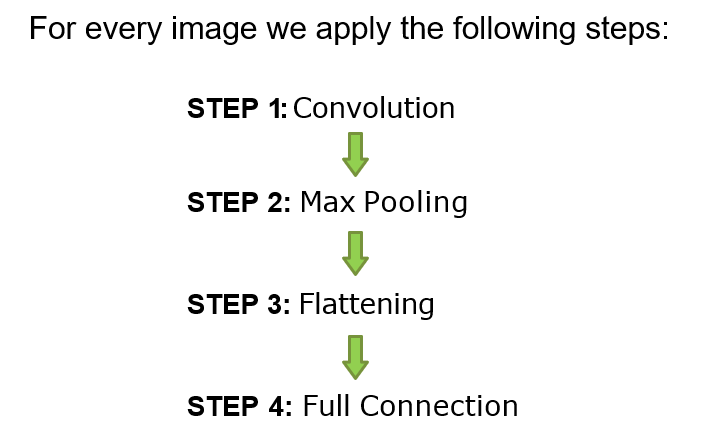

## Convolutional Layer
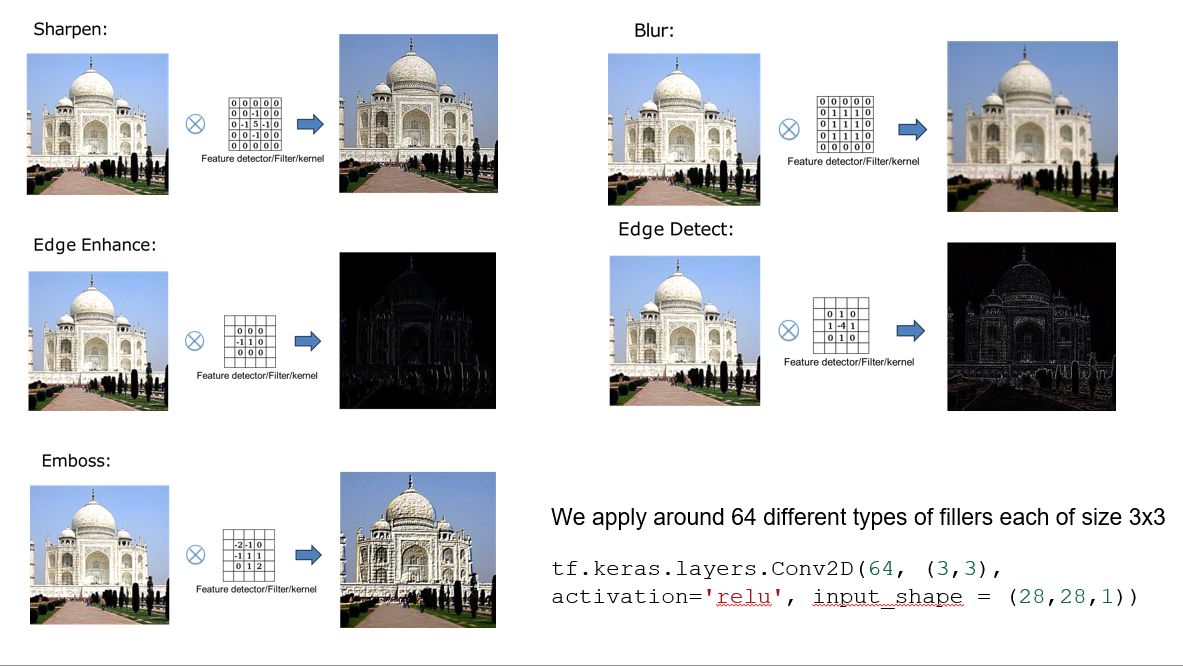

## Max Pooling Layer
#### Does not care at which part of the image our subject to detect is (even tilted or twisted)

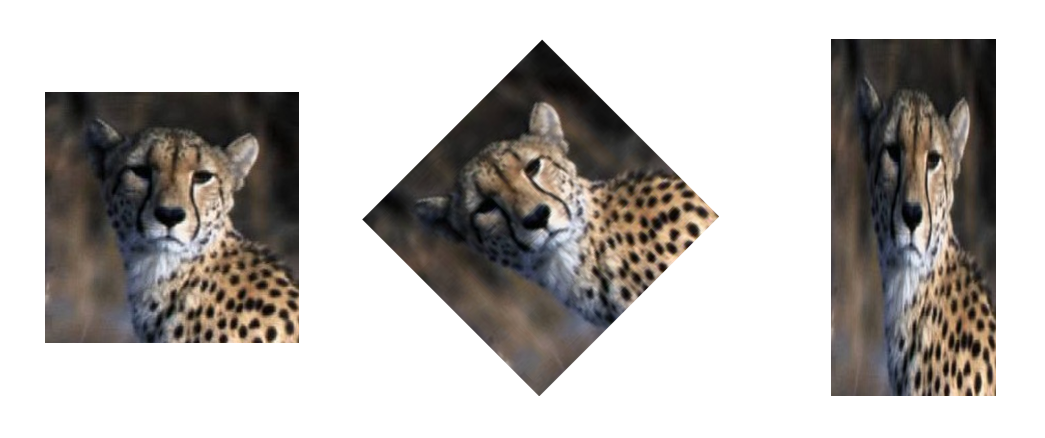

#Flatten


#### Flattens all the layers into a single layer making it ready for neural network

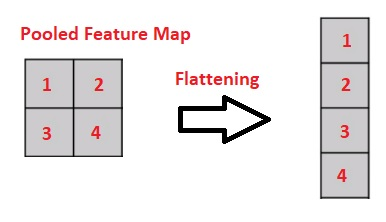

# Dense Layer
#### Dense layer is a fully connected layer, where every node is connected with every other node in the network

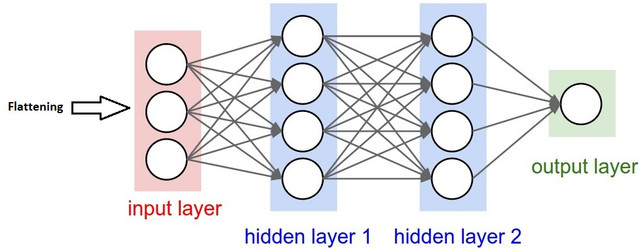

# Creating, Training & Saving the Model

In [15]:
# Sending training data into the built architecture to train
model = create_model()

# Training the model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 78s 90ms/step - loss: 2.5976 - accuracy: 0.1979 - val_loss: 1.5145 - val_accuracy: 0.5308
Epoch 2/15
858/858 [==============================] - 78s 91ms/step - loss: 1.6670 - accuracy: 0.4630 - val_loss: 0.9843 - val_accuracy: 0.6446
Epoch 3/15
858/858 [==============================] - 91s 106ms/step - loss: 1.2271 - accuracy: 0.5929 - val_loss: 0.7269 - val_accuracy: 0.7489
Epoch 4/15
858/858 [==============================] - 77s 90ms/step - loss: 0.9626 - accuracy: 0.6820 - val_loss: 0.6042 - val_accuracy: 0.7843
Epoch 5/15
858/858 [==============================] - 77s 90ms/step - loss: 0.7995 - accuracy: 0.7333 - val_loss: 0.4447 - val_accuracy: 0.8501
Epoch 6/15
858/858 [==============================] - 78s 91ms/step - loss: 0.6986 - accuracy: 0.7666 - val_loss: 0.3579 - val_accuracy: 0.8806
Epoch 7/15
858/858 [==============================] - 76s 88ms/step - loss: 0.6059 - accuracy: 0.7961 - val_loss: 0.3937 - val_accuracy

In [17]:
# Saving the model for future use without training, this saves all the model weights
model.save('Sign_language.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Now take a look at your training history:

# Plotting Loss & Accuracy

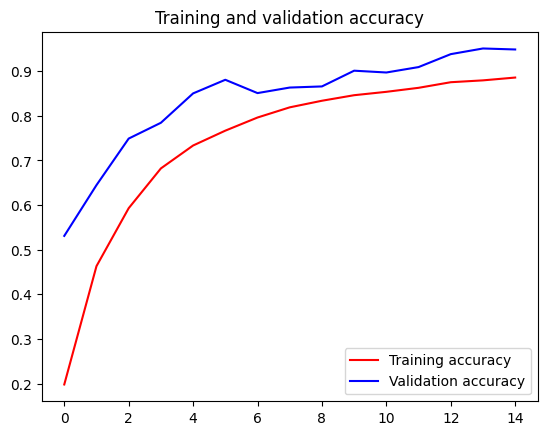

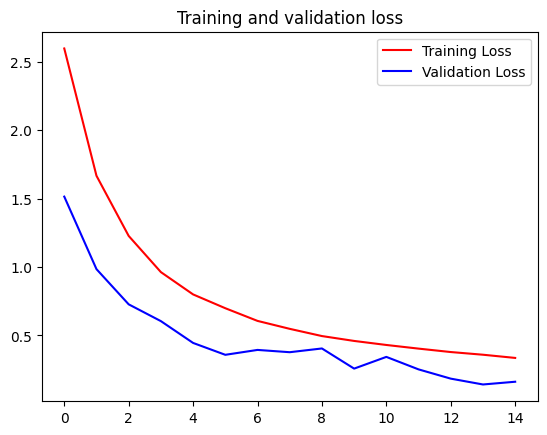

In [18]:
# Plotting the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predicting new value from data

Reference Image for Sign Language

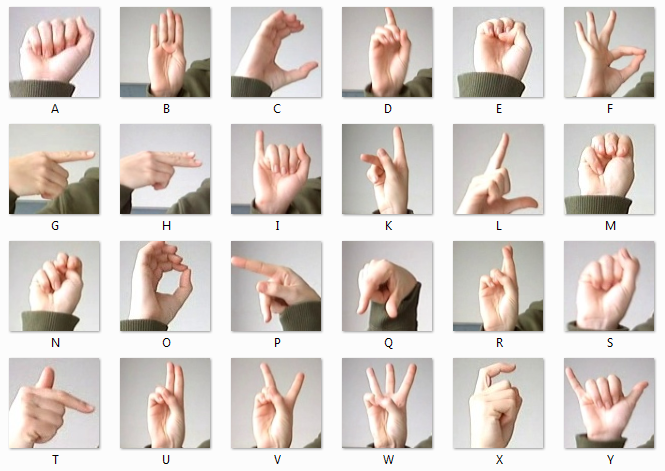

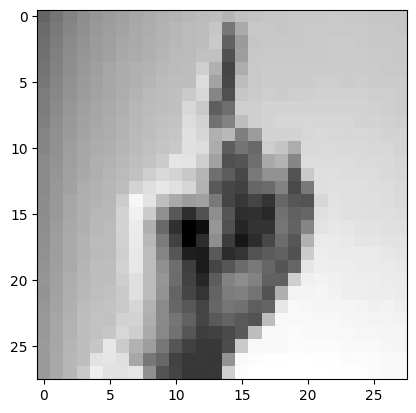

In [27]:
# Predicting new image (784 pixels)
import numpy as np
import matplotlib.pyplot as plt

# Assuming the 1x785 array is named 'data'
data = np.array([[107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,163,164,170,119,152,171,171,170,171,172,172,172,172,172,171,171,170,113,123,131,137,142,145,150,152,155,158,161,163,164,172,105,142,170,171,171,171,172,172,173,173,172,171,171,171,116,125,133,139,143,146,151,153,156,159,162,163,167,167,95,144,171,172,172,172,172,172,173,173,173,172,172,171,117,126,134,140,145,149,153,156,158,161,163,164,175,156,87,154,172,173,173,173,173,173,174,174,174,173,172,172,119,128,136,142,146,150,153,156,159,163,165,164,184,148,89,164,172,174,174,174,174,175,175,174,175,174,173,173,122,130,138,143,147,150,154,158,162,165,166,172,181,128,94,170,173,175,174,175,176,177,177,177,177,175,175,174,122,132,139,145,149,152,156,160,163,165,166,181,172,103,113,175,176,178,178,179,179,179,179,178,179,177,175,174,125,134,141,147,150,153,157,161,164,167,168,184,179,116,126,165,176,179,180,180,181,180,180,180,179,178,177,176,128,135,142,148,152,154,158,162,165,168,170,187,180,156,161,124,143,179,178,178,181,182,181,180,181,180,179,179,129,136,144,150,153,155,159,163,166,169,172,187,184,153,102,117,110,175,169,154,182,183,183,182,182,181,181,179,131,138,145,150,155,157,161,165,168,174,190,189,175,146,94,97,113,151,158,129,184,184,184,184,183,183,182,180,131,139,146,151,155,159,163,167,175,182,179,171,159,114,102,89,121,136,136,96,172,186,186,185,185,184,182,181,131,140,147,154,157,160,164,179,186,191,187,180,157,100,88,84,108,111,126,90,120,186,187,187,186,185,184,182,133,141,149,155,158,160,174,201,189,165,151,143,146,120,87,78,87,76,108,98,96,181,188,187,186,186,185,183,133,141,150,156,160,161,179,197,174,135,99,72,95,134,97,72,74,68,116,105,108,187,189,187,187,186,186,185,134,143,151,156,161,163,179,194,156,110,74,42,52,139,94,67,75,75,118,106,129,189,191,190,188,188,187,186,135,144,152,158,163,163,177,193,161,122,84,43,71,134,81,57,71,88,112,98,157,193,193,192,190,190,189,188,136,144,152,158,162,163,176,192,164,128,98,62,60,100,71,76,96,101,105,95,174,195,194,194,194,193,191,190,137,145,152,159,164,165,178,191,164,135,113,82,59,87,98,111,120,108,97,108,190,196,195,195,194,193,193,192,139,146,154,160,164,165,175,186,163,139,112,85,67,102,126,133,126,105,104,176,197,198,197,196,195,195,194,193,138,147,155,161,165,167,172,186,163,137,107,87,76,106,122,125,117,96,156,199,199,200,198,196,196,195,195,194,139,148,156,163,166,168,172,180,158,131,108,99,86,108,118,116,103,107,191,202,201,200,200,200,199,197,198,196,140,149,157,164,168,167,177,178,155,131,118,105,87,100,106,100,96,164,202,202,202,202,202,201,200,199,199,198,140,150,157,165,167,170,181,175,152,130,115,98,82,85,90,99,165,202,203,204,203,203,202,202,201,201,200,200,142,150,159,165,170,191,173,157,144,119,97,84,79,79,91,172,202,203,203,205,204,204,204,203,202,202,201,200,142,151,160,165,188,190,187,150,119,109,85,79,79,78,137,203,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202]]
)

# Remove the extra element
data = data[:, :784]

# Reshape the array
reshaped_data = data.reshape((28, 28, 1))

# Rescale the pixel values to the range [0, 1]
reshaped_data = reshaped_data/255.0

# Plot the image
plt.imshow(reshaped_data[:, :, 0], cmap='gray')  # Assuming it's a grayscale image
plt.show()


In [20]:
# Loading the saved model using TensorFlow library
from tensorflow.keras.models import load_model

new_model = load_model('/content/Sign_language.h5')

In [29]:
# Sending new image pixel data into the pre-trained model and predicting the value

# Create a dictionary to map numbers to letters
number_to_letter = {i: chr(ord('a') + i) for i in range(26)}

pixel_data = [[107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,163,164,170,119,152,171,171,170,171,172,172,172,172,172,171,171,170,113,123,131,137,142,145,150,152,155,158,161,163,164,172,105,142,170,171,171,171,172,172,173,173,172,171,171,171,116,125,133,139,143,146,151,153,156,159,162,163,167,167,95,144,171,172,172,172,172,172,173,173,173,172,172,171,117,126,134,140,145,149,153,156,158,161,163,164,175,156,87,154,172,173,173,173,173,173,174,174,174,173,172,172,119,128,136,142,146,150,153,156,159,163,165,164,184,148,89,164,172,174,174,174,174,175,175,174,175,174,173,173,122,130,138,143,147,150,154,158,162,165,166,172,181,128,94,170,173,175,174,175,176,177,177,177,177,175,175,174,122,132,139,145,149,152,156,160,163,165,166,181,172,103,113,175,176,178,178,179,179,179,179,178,179,177,175,174,125,134,141,147,150,153,157,161,164,167,168,184,179,116,126,165,176,179,180,180,181,180,180,180,179,178,177,176,128,135,142,148,152,154,158,162,165,168,170,187,180,156,161,124,143,179,178,178,181,182,181,180,181,180,179,179,129,136,144,150,153,155,159,163,166,169,172,187,184,153,102,117,110,175,169,154,182,183,183,182,182,181,181,179,131,138,145,150,155,157,161,165,168,174,190,189,175,146,94,97,113,151,158,129,184,184,184,184,183,183,182,180,131,139,146,151,155,159,163,167,175,182,179,171,159,114,102,89,121,136,136,96,172,186,186,185,185,184,182,181,131,140,147,154,157,160,164,179,186,191,187,180,157,100,88,84,108,111,126,90,120,186,187,187,186,185,184,182,133,141,149,155,158,160,174,201,189,165,151,143,146,120,87,78,87,76,108,98,96,181,188,187,186,186,185,183,133,141,150,156,160,161,179,197,174,135,99,72,95,134,97,72,74,68,116,105,108,187,189,187,187,186,186,185,134,143,151,156,161,163,179,194,156,110,74,42,52,139,94,67,75,75,118,106,129,189,191,190,188,188,187,186,135,144,152,158,163,163,177,193,161,122,84,43,71,134,81,57,71,88,112,98,157,193,193,192,190,190,189,188,136,144,152,158,162,163,176,192,164,128,98,62,60,100,71,76,96,101,105,95,174,195,194,194,194,193,191,190,137,145,152,159,164,165,178,191,164,135,113,82,59,87,98,111,120,108,97,108,190,196,195,195,194,193,193,192,139,146,154,160,164,165,175,186,163,139,112,85,67,102,126,133,126,105,104,176,197,198,197,196,195,195,194,193,138,147,155,161,165,167,172,186,163,137,107,87,76,106,122,125,117,96,156,199,199,200,198,196,196,195,195,194,139,148,156,163,166,168,172,180,158,131,108,99,86,108,118,116,103,107,191,202,201,200,200,200,199,197,198,196,140,149,157,164,168,167,177,178,155,131,118,105,87,100,106,100,96,164,202,202,202,202,202,201,200,199,199,198,140,150,157,165,167,170,181,175,152,130,115,98,82,85,90,99,165,202,203,204,203,203,202,202,201,201,200,200,142,150,159,165,170,191,173,157,144,119,97,84,79,79,91,172,202,203,203,205,204,204,204,203,202,202,201,200,142,151,160,165,188,190,187,150,119,109,85,79,79,78,137,203,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202]]
import numpy as np

# Assuming your 1x785 array is named 'data'
data = np.array(pixel_data)  # Replace '...' with your actual data

# Remove the extra element
data = data[:, :784]

# Reshape the array
reshaped_data = data.reshape((-1,28, 28))

image_to_predict = np.expand_dims(reshaped_data, axis=3)
image_to_predict = image_to_predict/255
new_model.predict(image_to_predict)
predicted_letter = np.argmax(model.predict(image_to_predict))
print("predicting...")
print(f"The image is predicted to be of label: {predicted_letter}")
print(f"Predicted letter is: {number_to_letter[predicted_letter]}")


1/1 [==============================] - 0s 27ms/step
predicting...
The image is predicted to be of label: 3
Predicted letter is: d


# Practical Applications

**Integration with live conferencing Platforms**: Can integrate it with Zoom or other live conferencing platforms to automatically classify Sign Language symbols which can be used to create a form of real-time captioning.

**Accessibility for the Deaf and Hard of Hearing**: Sign language is the primary means of communication for many deaf and hard-of-hearing individuals. ML models that can recognize and interpret sign language can be used to develop applications or devices that enhance accessibility. For example, such systems can be integrated into devices to translate sign language into text or speech, facilitating communication between deaf individuals and those who don't understand sign language.

**Human-Computer Interaction (HCI)**: ML models for sign language recognition can be used in HCI scenarios where users interact with computers or devices using gestures. This can be especially relevant in scenarios where traditional input methods are challenging or not feasible.

**Assistive Technology**: ML applications can contribute to the development of assistive technologies that enhance the overall quality of life for individuals with hearing impairments. This includes applications that aid in job searches, social interactions, and daily activities.